In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

%matplotlib notebook

In [3]:
%matplotlib notebook

In [4]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_activity_diff'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
ext_list =['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


In [5]:
#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

('angle_center:', 22.5)
('min centered angle:', -157.47162455426732)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


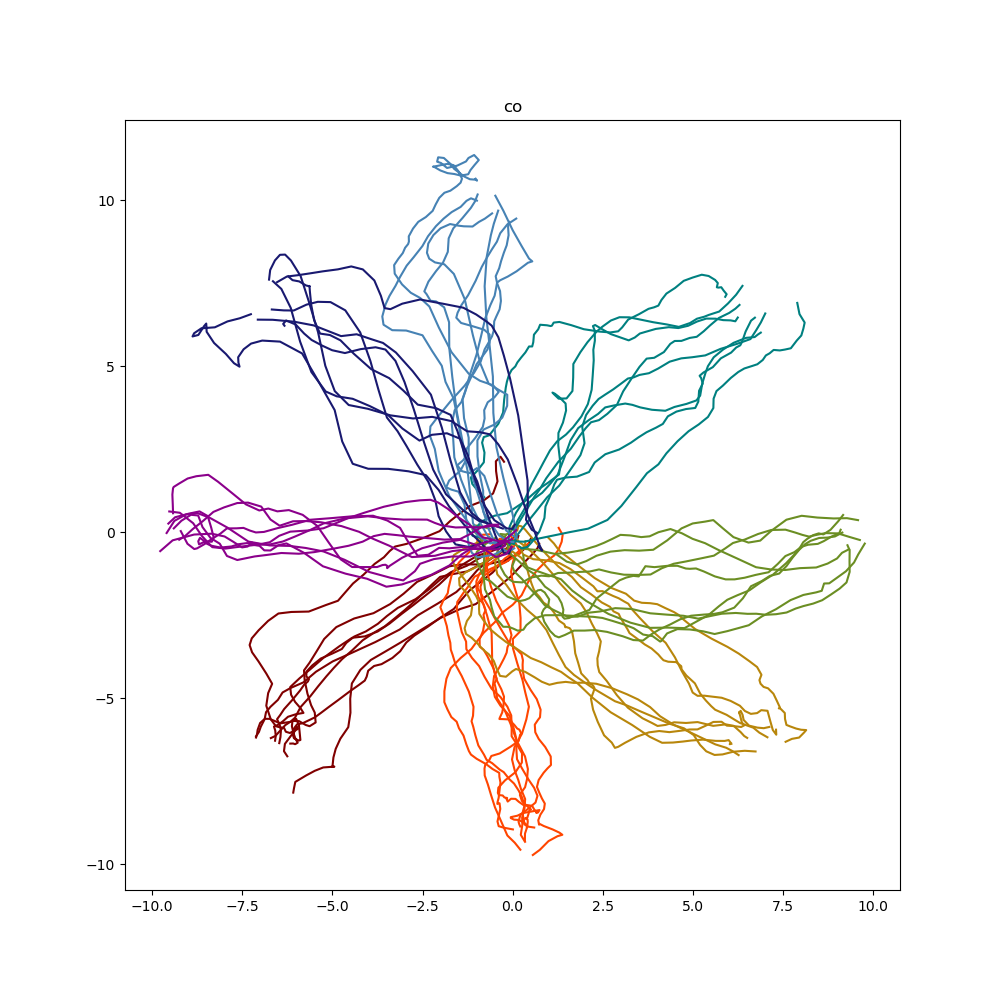

<IPython.core.display.Javascript object>


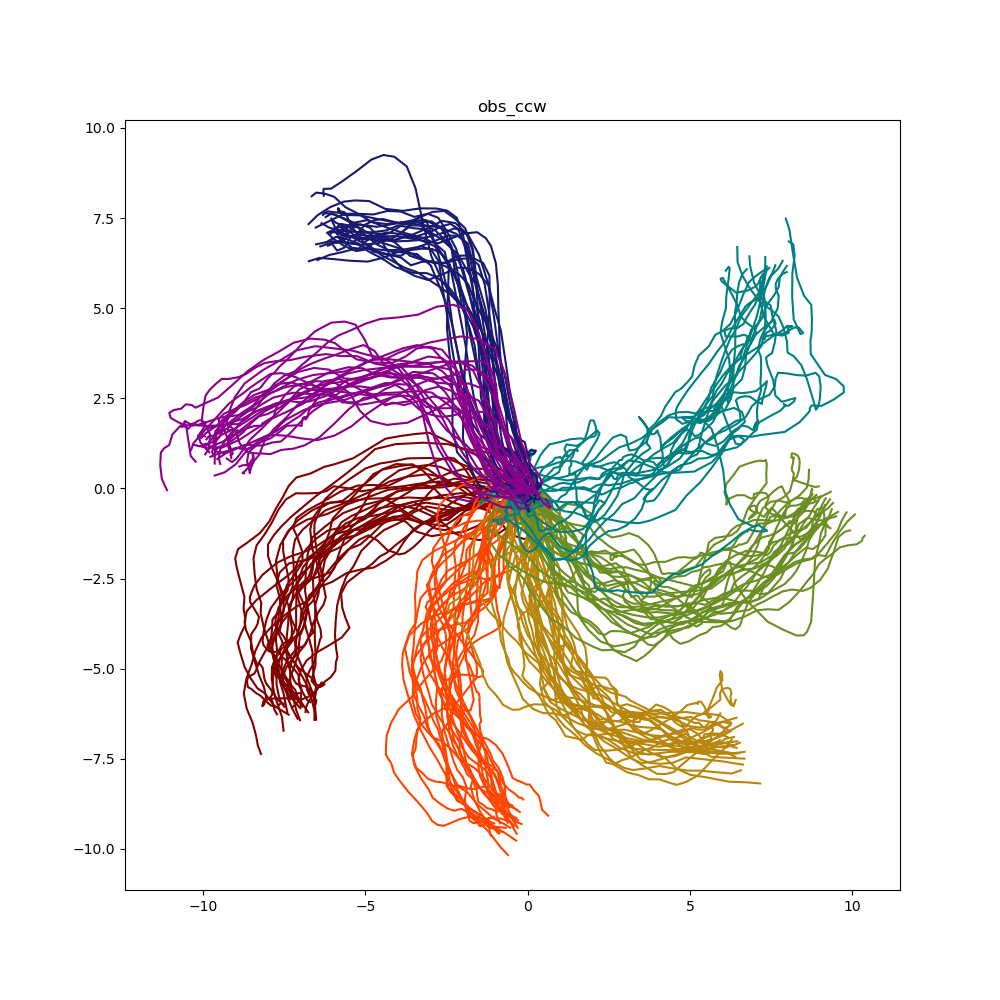

<IPython.core.display.Javascript object>


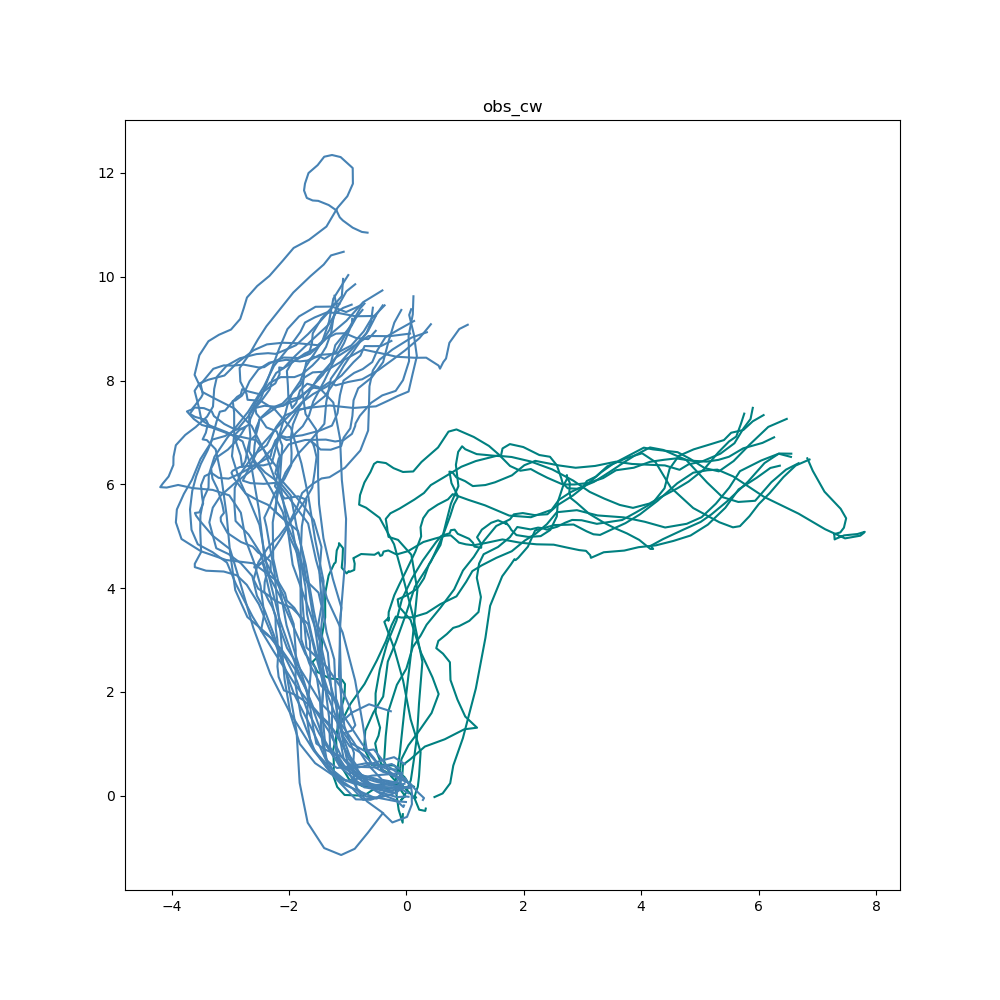

In [6]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

<IPython.core.display.Javascript object>


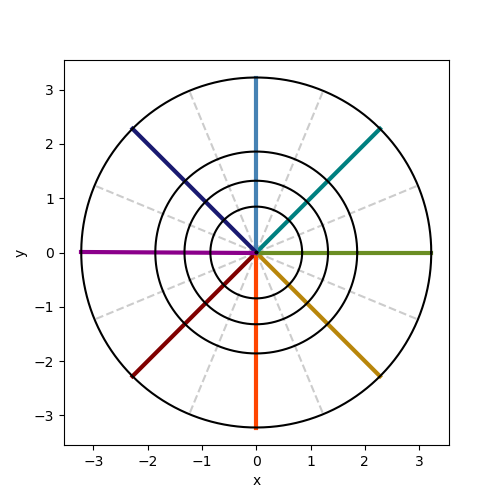

In [8]:
num_mag_bins_analyze=4
def plot_command_bin(): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges[:,:(num_mag_bins_analyze)], target_color)
    
plt.figure(figsize=(5,5))
plot_command_bin()    

### Plot an example trial

<IPython.core.display.Javascript object>


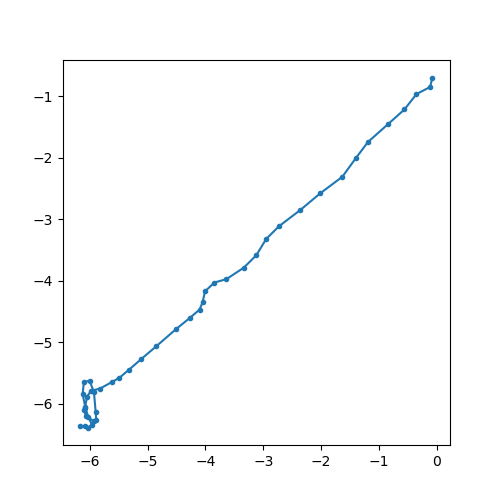

In [9]:
trial = 1

sel_trial = (df['trial_global']==trial)
sel_bin = (df['bin']>=0)
sel = sel_trial&sel_bin

x = df.loc[sel, 'kin_px']
y = df.loc[sel, 'kin_py']

plt.figure(figsize=(5,5))
plt.plot(x,y, '.-')

### Neural dynamics 

In [10]:
n_list = ['n_'+ str(i) for i in np.arange(num_neurons)]

sel_t_bin = (df['bin'] >= 0)
sel_t_bin_end = (df['bin_end'] >= 1)
sel_t = (sel_t_bin)&(sel_t_bin_end)
n_t = df.loc[sel_t,n_list]

sel_tp1_bin = (df['bin'] >= 1)
sel_tp1_bin_end = (df['bin_end'] >= 0)
sel_tp1 = (sel_tp1_bin)&(sel_tp1_bin_end)
n_tp1 = df.loc[sel_tp1,n_list]

In [11]:
n_t.head()

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,n_34,n_35,n_36,n_37,n_38,n_39,n_40,n_41,n_42,n_43
0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,3.0,3.0,7.0,1.0,2.0
1,1.0,1.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,...,1.0,3.0,1.0,1.0,2.0,1.0,2.0,4.0,0.0,1.0
2,1.0,1.0,1.0,0.0,0.0,3.0,1.0,2.0,0.0,0.0,...,0.0,1.0,3.0,2.0,3.0,3.0,4.0,11.0,0.0,5.0
3,2.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,2.0,1.0,4.0,6.0,1.0,5.0
4,0.0,0.0,0.0,0.0,3.0,1.0,3.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,2.0,1.0,3.0,3.0,0.0,1.0


In [12]:
n_tp1.head()

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,n_34,n_35,n_36,n_37,n_38,n_39,n_40,n_41,n_42,n_43
1,1.0,1.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,...,1.0,3.0,1.0,1.0,2.0,1.0,2.0,4.0,0.0,1.0
2,1.0,1.0,1.0,0.0,0.0,3.0,1.0,2.0,0.0,0.0,...,0.0,1.0,3.0,2.0,3.0,3.0,4.0,11.0,0.0,5.0
3,2.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,2.0,1.0,4.0,6.0,1.0,5.0
4,0.0,0.0,0.0,0.0,3.0,1.0,3.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,2.0,1.0,3.0,3.0,0.0,1.0
5,3.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,2.0,0.0,6.0,0.0,3.0


In [13]:
# regression: 
#ridge parameter from Preeya: 2500
clf = Ridge(alpha=2500)
clf.fit(np.array(n_t), np.array(n_tp1))

Ridge(alpha=2500, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [14]:
An = clf.coef_
bn = clf.intercept_

In [15]:
#Put into numpy matrices
An_m = np.mat(An)
bn_m = np.mat(bn).T

n_t_m = np.mat(n_t).T
n_tp1_m = np.mat(n_tp1).T
nhat_tp1 = An_m*n_t_m+bn_m

In [16]:
#sanity check we can use the dynamics parameters:
total_cov = np.cov(n_tp1_m)
total_var = np.trace(total_cov)

res_hat = nhat_tp1-n_tp1_m #44 x num_obs
res_cov = np.cov(res_hat) #44 x 44
res_var = np.trace(res_cov)

pred_cov = np.cov(nhat_tp1)
pred_var = np.trace(pred_cov)

print('viveks test R2: ', 1-res_var/total_var)
print('true R2: ', clf.score(n_t, n_tp1))

('viveks test R2: ', 0.24517725254512746)
('true R2: ', 0.2451772525451282)


### Form matrices

In [18]:
kin_var = ['kin_px', 'kin_py', 'kin_vx', 'kin_vy']
offset_var = ['offset']

#F: 5x5
sel_F = np.array([0,2,3,5,6])
F = decoder['F'][sel_F, :]
F = F[:,sel_F]
print(F.shape)
F = xr.DataArray(F, coords={'out':kin_var+offset_var, 'in':kin_var+offset_var}, dims=['out', 'in'])

#K: 5xnum_neurons
sel_K = np.array([0,2,3,5,6])
Kn = decoder['K'][sel_K, :] #decoder mapping neural to control

(5L, 5L)


In [58]:
#A matrix of neural dynamics and cursor dynamics:
#A_top: [An, 0, bn]
#A_bot: [Kn, F]

zero_n_dynamics = False
zero_n_offset = False

num_kin = 4
n_z = np.zeros((num_neurons, num_neurons))
n_k_z = np.zeros((num_neurons, num_kin))
no_z = np.zeros((num_neurons,1))

if zero_n_dynamics and zero_n_offset:
    A_top = np.hstack((n_z, n_k_z, no_z))
elif zero_n_dynamics:
    A_top = np.hstack((n_z, n_k_z, bn_m))
else:
    A_top = np.hstack((An_m, n_k_z, bn_m))

A_bot = np.hstack((Kn, F))
A = np.vstack((A_top, A_bot))

In [68]:
#A matrix of neural dynamics and cursor dynamics:
#n_d - neural dynamics
#n_o - neural offset
#
#A_top: [An, 0, bn]
#A_bot: [Kn, F]
#
#Assemble A matrices with zero-ed out neural dynamics and neural offset 
A_list = ['n_do', 'n_o', 'n_null']
A_dic = {}

num_kin = 4
n_z = np.zeros((num_neurons, num_neurons))
n_k_z = np.zeros((num_neurons, num_kin))
no_z = np.zeros((num_neurons,1))

A_bot = np.hstack((Kn, F))

A_top_n_do = np.hstack((An_m, n_k_z, bn_m))
A_dic['n_do'] = np.vstack((A_top_n_do, A_bot))

A_top_n_o = np.hstack((n_z, n_k_z, bn_m))
A_dic['n_o'] = np.vstack((A_top_n_o, A_bot))

A_top_n_null = np.hstack((n_z, n_k_z, no_z))
A_dic['n_null'] = np.vstack((A_top_n_null, A_bot))



In [69]:
#B matrix of inputs to neural dynamics:
#B_top = eye(num_neurons)
#B_bot = 0
num_non_n = num_kin+1
B = np.vstack((np.eye(num_neurons), np.zeros((num_non_n, num_neurons))))

In [70]:
#Q,R:
#State Cost Q: 
state_dim = num_neurons+num_kin+1
state_label = n_list+kin_var+offset_var
Q = np.zeros((state_dim,state_dim))
Q_da = xr.DataArray(Q, coords={'out':state_label, 'in':state_label}, dims=['out', 'in'])
# #set values for cursor position: 
Q_da.loc['kin_px', 'kin_px'] = 1
Q_da.loc['kin_py', 'kin_py'] = 1
Q = np.mat(Q_da)

#Input Cost R:
input_dim = num_neurons
R_scalar = 1e3
R = np.eye(input_dim)*R_scalar
print(Q)
print(R)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1000.    0.    0. ...    0.    0.    0.]
 [   0. 1000.    0. ...    0.    0.    0.]
 [   0.    0. 1000. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ... 1000.    0.    0.]
 [   0.    0.    0. ...    0. 1000.    0.]
 [   0.    0.    0. ...    0.    0. 1000.]]


In [ ]:
# #check Q da:
# plt.figure(figsize=(5,5))
# plt.imshow(Q_da)

In [77]:
#Models: 
lqr_m = {}
for k in A_list:
    lqr_m[k] = {}
    lqr_m[k]['A'] = np.mat(A_dic[k])
    lqr_m[k]['B'] = np.mat(B)
    lqr_m[k]['Q'] = np.mat(Q)
    lqr_m[k]['R'] = np.mat(R)
    lqr_m[k]['R_scalar'] = R_scalar

    
for k in A_list:
    #unpack:
    A = lqr_m[k]['A']
    B = lqr_m[k]['B']
    Q = lqr_m[k]['Q']
    R = lqr_m[k]['R']
    K = bmi_b.solve_lqr_K_inf_horizon(A,B,Q,R)
    lqr_m[k]['K'] = K

('converged!:', 1300)
('converged!:', 2341)
('converged!:', 2528)


<IPython.core.display.Javascript object>


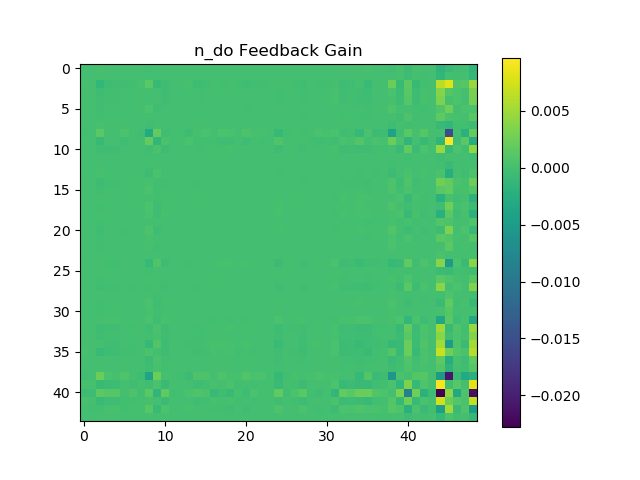

<IPython.core.display.Javascript object>


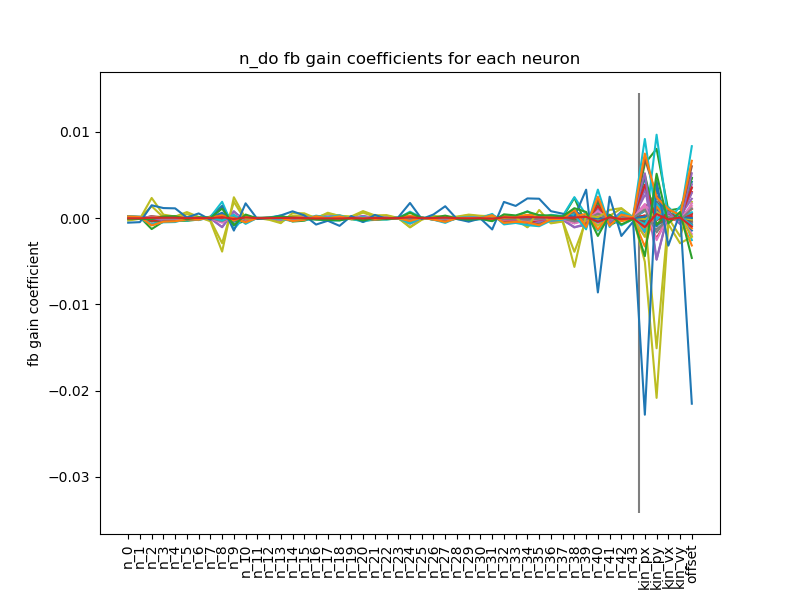

<IPython.core.display.Javascript object>


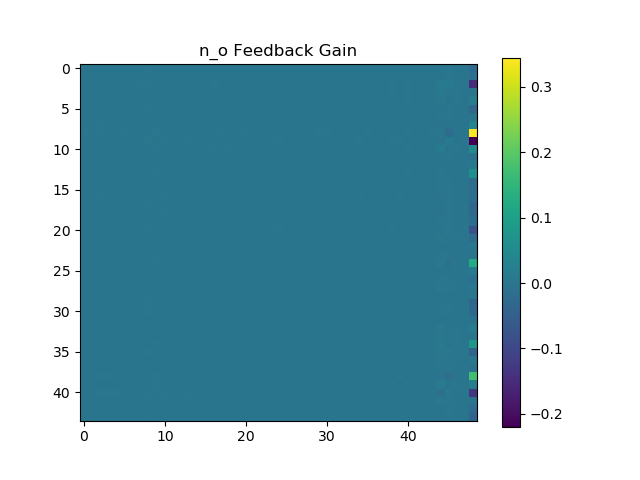

<IPython.core.display.Javascript object>


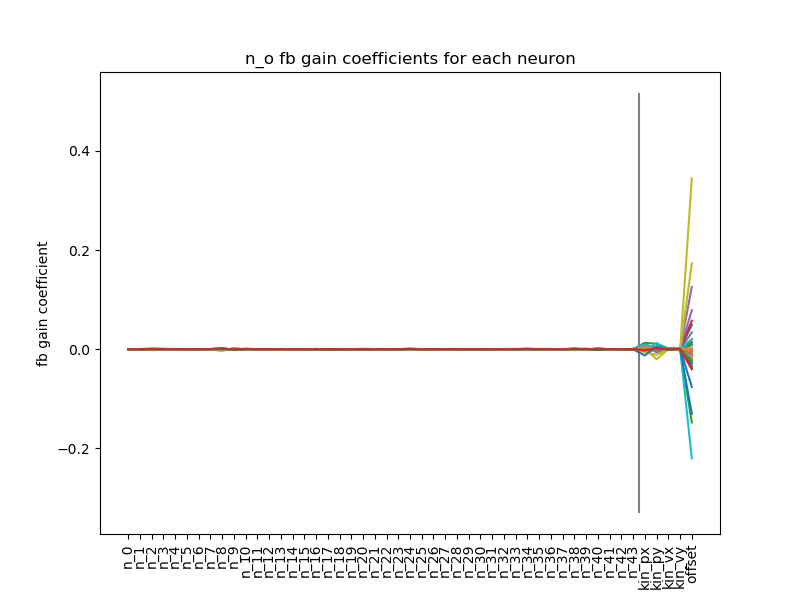

<IPython.core.display.Javascript object>


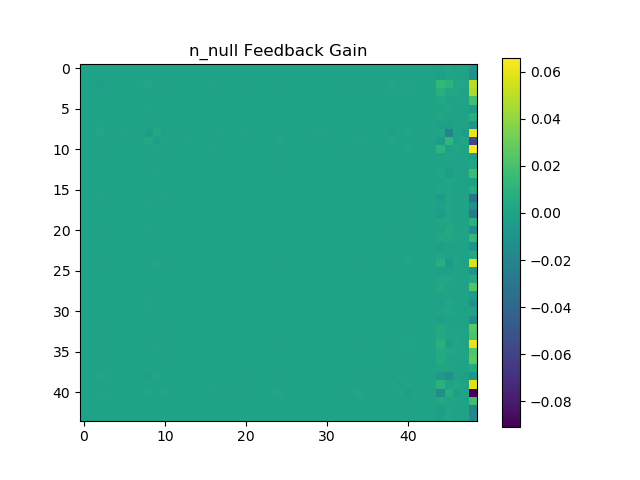

<IPython.core.display.Javascript object>


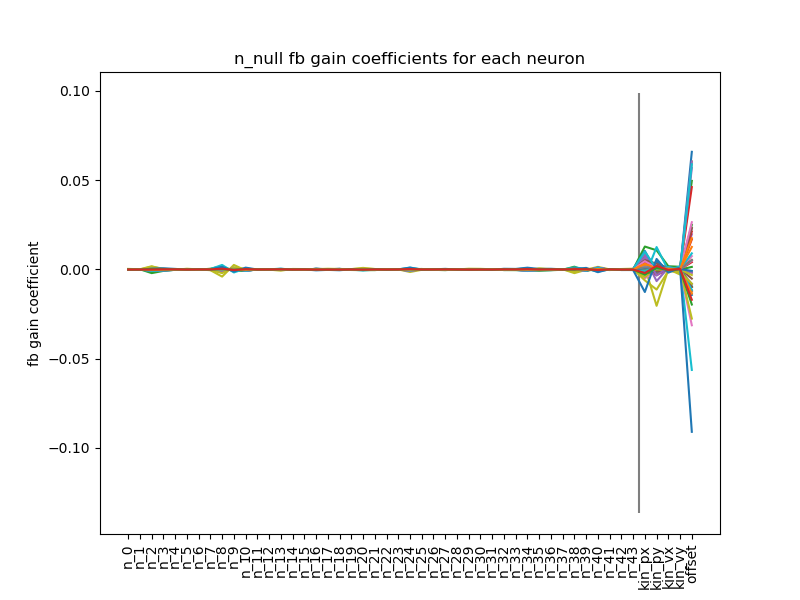

In [80]:
#Visualize the feedback gain:
for k in A_list: 
    K = lqr_m[k]['K']
    plt.figure()
    plt.imshow(K)
    plt.colorbar()
    plt.title(k+' Feedback Gain')
    #This is interesting!! I want to inspect this... 

    plt.figure(figsize=(8,6))
    _=plt.plot(K.T)
    plt.vlines(43.5,K.min()*1.5, K.max()*1.5,alpha=0.5)
    _=plt.xticks(np.arange(state_dim),state_label,rotation=90)
    plt.ylabel('fb gain coefficient')
    plt.title(k+ ' fb gain coefficients for each neuron')

<IPython.core.display.Javascript object>


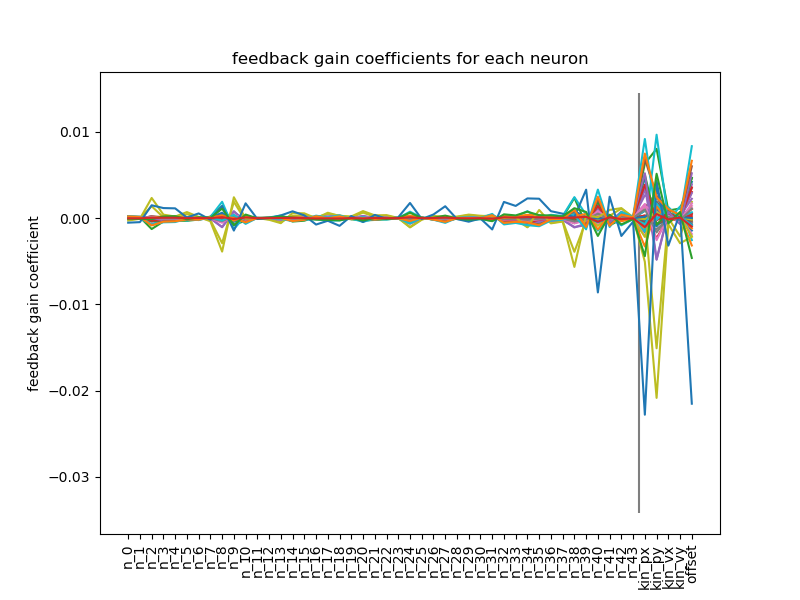

Text(0.5,1,'feedback gain coefficients for each neuron')

### lqr to target state

In [185]:
#Target and Initial State:
#--------------------------------------------------------------------
#Target: 
target = np.unique(df.loc[sel,'target']).astype(int)
T = np.squeeze(target_pos[target,:])
state_T = np.mat([T[0], T[1], 0, 0, 0]).T
n_z = np.mat(np.zeros(num_neurons)).T
state_T = np.vstack((n_z, state_T))

#Initial state (center of workspace)
state_init = np.zeros(state_dim)
state_init[-1] = 1 #for now, start neural activity at zeros
state_init = np.mat(state_init).T


(49L, 1L)

In [89]:
lqr_sim = {}
for k in A_list:
    lqr_sim[k] = {}
    #unpack:
    A = lqr_m[k]['A']
    B = lqr_m[k]['B']
    K = lqr_m[k]['K']
    
    u_da, state_da, sim_len = bmi_b.sim_lqr_nk_co_trial(A,B,K,\
                           target=state_T,state_init=state_init, state_label=state_label, input_label=n_list, num_neurons=num_neurons)
    
    #assign:
    lqr_sim[k]['u_da'] = u_da
    lqr_sim[k]['state_da'] = state_da
    lqr_sim[k]['sim_len'] = sim_len

<IPython.core.display.Javascript object>


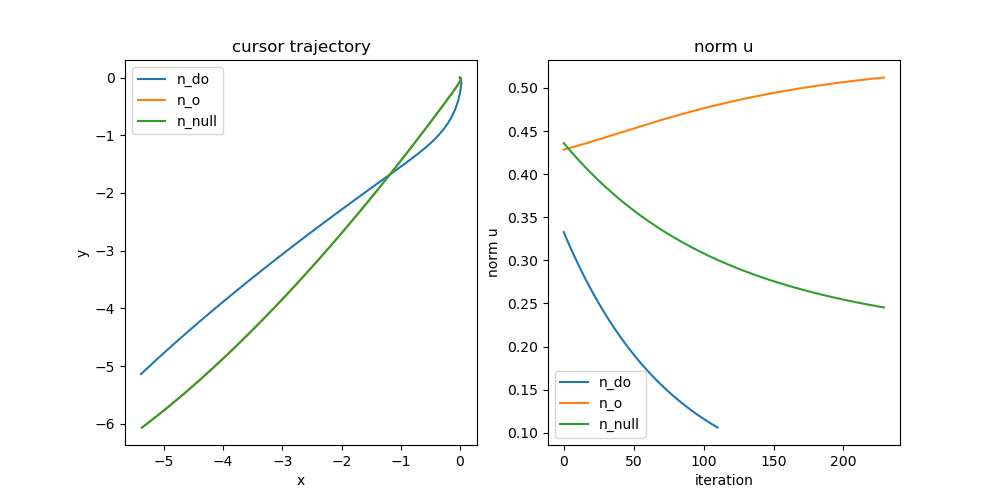

In [104]:
#Plot each on the same subplot
#Visualize results: 
plt.figure(figsize=(10,5))

#------------------------------------------------------------------
#CURSOR PLOTS:
plt.subplot(1,2,1)
for k in A_list:
    state_da = lqr_sim[k]['state_da']
    sim_len = lqr_sim[k]['sim_len']
    
    x = state_da.loc['kin_px',np.arange(0,sim_len)]
    y = state_da.loc['kin_py',np.arange(0,sim_len)]        
    
    plt.plot(x,y,'-', label=k)
plt.xlabel('x')
plt.ylabel('y')
plt.title(k)
plt.legend()
plt.title('cursor trajectory')        

#------------------------------------------------------------------
#INPUT PLOTS:
plt.subplot(1,2,2)
for k in A_list:
    u_da = lqr_sim[k]['u_da']    
    norm_u = np.linalg.norm(u_da,axis=0)
    plt.plot(norm_u,'-',label=k)
plt.xlabel('iteration')
plt.ylabel('norm u')
plt.title('norm u')
plt.legend()

    
    

# for k in A_list:
#     u_da = lqr_sim[k]['state_da']
#     sim_len = lqr_sim[k]['sim_len']
    
#     x = state_da.loc['kin_px',np.arange(0,sim_len)]
#     y = state_da.loc['kin_py',np.arange(0,sim_len)]        
    
#     plt.plot(x,y,'-', label=k)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title(k)
# plt.legend()
# plt.title('cursor trajectory')







In [ ]:
for k in A_list:
    state_da = lqr_sim[k]['state_da']
    u_da = lqr_sim[k]['u_da']
    sim_len = lqr_sim[k]['sim_len']
    #------------------------------------------------------------------
    #CURSOR PLOTS:
    x = state_da.loc['kin_px',np.arange(0,sim_len)]
    y = state_da.loc['kin_py',np.arange(0,sim_len)]    

    #trajectory
    plt.subplot(1,3,2)
    plt.plot(x,y,'-')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(k)
    plt.legend()
    plt.title('cursor trajectory')    
    
    #------------------------------------------------------------------
    #input norm: 
    
    norm_u = np.linalg.norm(u_da,axis=0)
    plt.subplot(1,3,3)
    plt.plot(norm_u,'-',label='norm u')
    plt.xlabel('iteration')
    plt.ylabel('norm u')
    plt.title(k+ ' norm u')
    plt.legend()


<IPython.core.display.Javascript object>


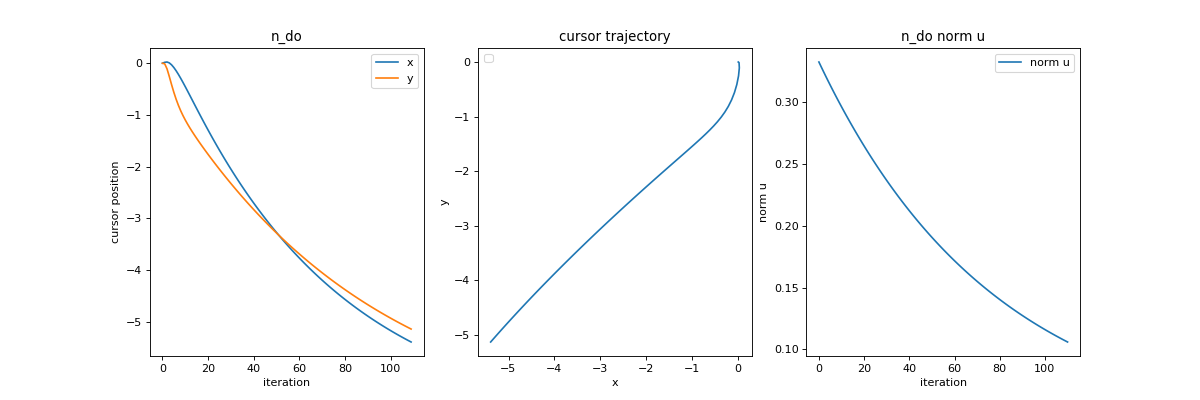

<IPython.core.display.Javascript object>


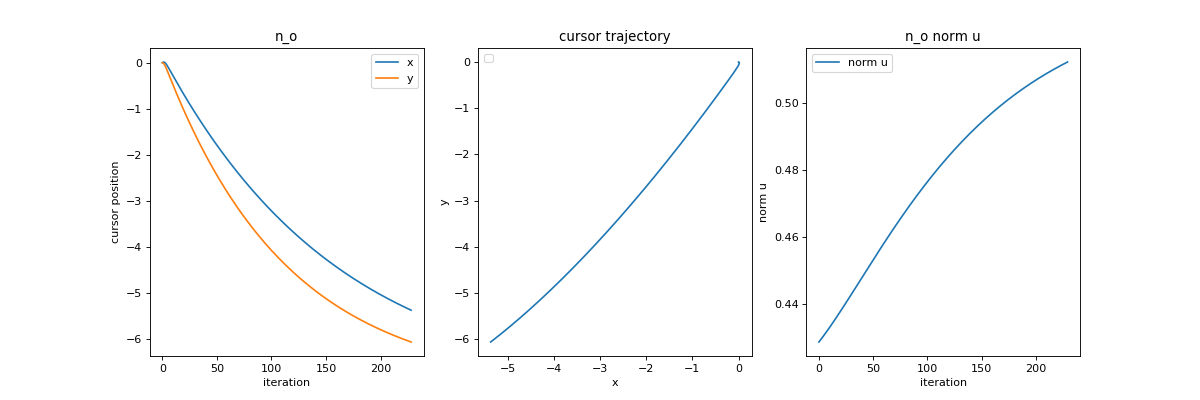

<IPython.core.display.Javascript object>


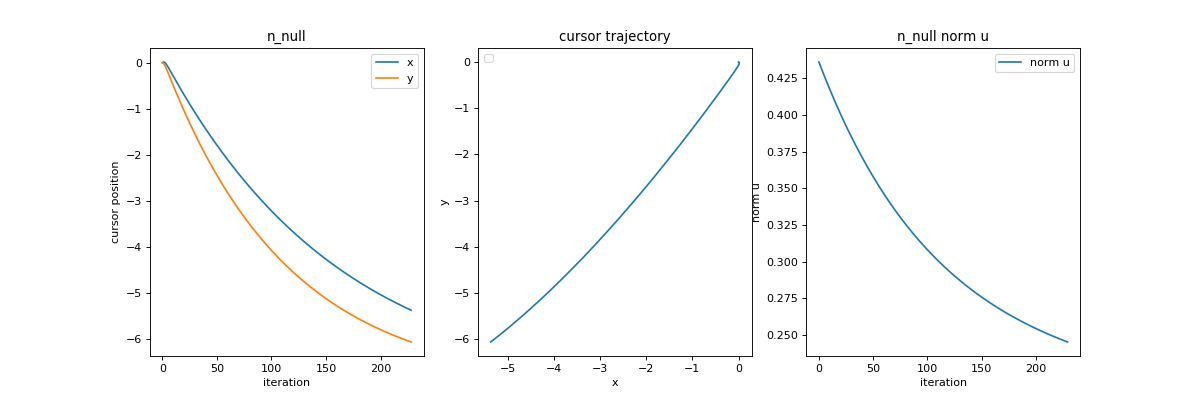

In [98]:
#Visualize results: 
for k in A_list:
    state_da = lqr_sim[k]['state_da']
    u_da = lqr_sim[k]['u_da']
    sim_len = lqr_sim[k]['sim_len']
    #------------------------------------------------------------------
    #CURSOR PLOTS:
    x = state_da.loc['kin_px',np.arange(0,sim_len)]
    y = state_da.loc['kin_py',np.arange(0,sim_len)]    
    
    #each coordinate: 
    plt.figure(figsize=((15,5)))
    plt.subplot(1,3,1)
    plt.plot(x,'-',label='x')
    plt.plot(y,'-',label='y')
    plt.xlabel('iteration')
    plt.ylabel('cursor position')
    plt.title(k)
    plt.legend()

    #trajectory
    plt.subplot(1,3,2)
    plt.plot(x,y,'-')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(k)
    plt.legend()
    plt.title('cursor trajectory')    
    
    #------------------------------------------------------------------
    #input norm: 
    
    norm_u = np.linalg.norm(u_da,axis=0)
    plt.subplot(1,3,3)
    plt.plot(norm_u,'-',label='norm u')
    plt.xlabel('iteration')
    plt.ylabel('norm u')
    plt.title(k+ ' norm u')
    plt.legend()


In [ ]:
num_plot = sim_len #num_iter
x = state_da.loc['kin_px',np.arange(0,num_plot)]
y = state_da.loc['kin_py',np.arange(0,num_plot)]
# x = state_da.loc['kin_px',:]
# y = state_da.loc['kin_py',:]

#each coordinate: 
plt.figure(figsize=(5,5))
plt.plot(x,'.-',label='x')
plt.plot(y,'.-',label='y')
plt.xlabel('iteration')
plt.ylabel('cursor position')
plt.legend()

#trajectory
plt.figure(figsize=(5,5))
plt.plot(x,y,'.-')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('cursor trajectory')

#------------------------------------------------------------
#input: 
num_plot = sim_len
# x = u_da.loc['u_vx',np.arange(0,num_plot)]
# y = u_da.loc['u_vy',np.arange(0,num_plot)]

# #each coordinate: 
# plt.figure(figsize=(5,5))
# plt.plot(x,'-',label='u_vx')
# plt.plot(y,'-',label='u_vy')
# plt.xlabel('iteration')
# plt.ylabel('u')
# plt.title('u components')
# plt.legend()

norm_u = np.linalg.norm(u_da,axis=0)
plt.figure(figsize=(5,5))
plt.plot(norm_u[:num_plot],'-',label='norm u')
plt.xlabel('iteration')
plt.ylabel('norm u')
plt.title('norm u')
plt.legend()

In [220]:
#Target: 
target = np.unique(df.loc[sel,'target']).astype(int)
T = np.squeeze(target_pos[target,:])
state_T = np.mat([T[0], T[1], 0, 0, 0]).T
n_z = np.mat(np.zeros(num_neurons)).T
state_T = np.vstack((n_z, state_T))

#Initial state
state_init = np.zeros(state_dim)
state_init[-1] = 1 #for now, start neural activity at zeros
state_init = np.mat(state_init).T

state_e_init = state_init-state_T
state_e_list = []
state_e = state_e_init
state_e_list.append(state_e)

#Initial input
u_var = n_list
u_list = []
u = K*state_e
u_list.append(u)

#Simulate trial: 
trial_complete = False
hold_req = 2
target_r = target_r_task[0]

max_iter = 10000
sim_len = 0
hold_i = 0

while not trial_complete: 
    state_e = (A+B*K)*state_e
    state_e_list.append(state_e)
    
    u = K*state_e
    u_list.append(u)    
    
    dist2target = np.linalg.norm(state_e[num_neurons:(num_neurons+1)])
    if dist2target <= target_r:
        hold_i+=1
    else:
        hold_i=0
    if(hold_i>=hold_req):
        trial_complete = True
    sim_len+=1

#RESULTS:
#input:
u_mat = np.array(u_list)
u_mat = u_mat.squeeze().T
u_da = xr.DataArray(u_mat, coords={'v':u_var,'obs':np.arange(sim_len+1)}, dims=['v', 'obs'])

#state error:
state_e_mat = np.array(state_e_list)
state_e_mat = state_e_mat.squeeze().T
state_e_da = xr.DataArray(state_e_mat, coords={'v':n_list+kin_var,'obs':np.arange(sim_len+1)}, dims=['v', 'obs'])

#state:
state_mat = copy.deepcopy(state_e_mat)
state_mat[num_neurons:,:] = state_mat[num_neurons:,:] + state_T[num_neurons:,:]
state_da = xr.DataArray(state_mat, coords={'v':n_list+kin_var,'obs':np.arange(sim_len+1)}, dims=['v', 'obs'])

In [205]:
state_init[num_neurons:,:]

matrix([[0.],
        [0.],
        [0.],
        [0.],
        [1.]])

In [204]:
state_T[num_neurons:,:]

matrix([[-7.07106781],
        [-7.07106781],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]])

In [203]:
state_da[num_neurons:, :]

<xarray.DataArray (v: 5, obs: 111)>
array([[-7.071068, -6.390346, -6.062661, ..., -5.773248, -5.773173, -5.773099],
       [-7.071068, -6.390346, -6.062661, ..., -5.773248, -5.773173, -5.773099],
       [ 0.      ,  0.680722,  1.008407, ...,  1.29782 ,  1.297895,  1.297969],
       [ 0.      ,  0.680722,  1.008407, ...,  1.29782 ,  1.297895,  1.297969],
       [ 0.      ,  0.680722,  1.008407, ...,  1.29782 ,  1.297895,  1.297969]])
Coordinates:
  * obs      (obs) int32 0 1 2 3 4 5 6 7 8 ... 103 104 105 106 107 108 109 110
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'

<IPython.core.display.Javascript object>


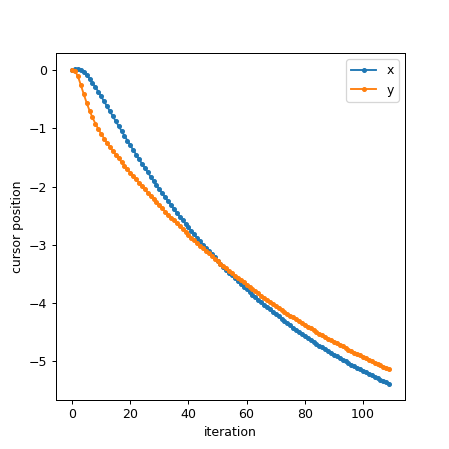

<IPython.core.display.Javascript object>


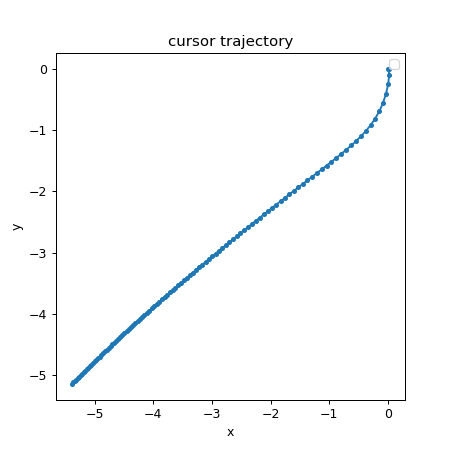

<IPython.core.display.Javascript object>


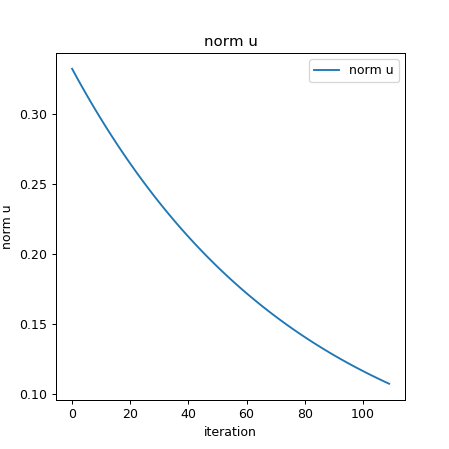

In [223]:
num_plot = sim_len #num_iter
x = state_da.loc['kin_px',np.arange(0,num_plot)]
y = state_da.loc['kin_py',np.arange(0,num_plot)]
# x = state_da.loc['kin_px',:]
# y = state_da.loc['kin_py',:]

#each coordinate: 
plt.figure(figsize=(5,5))
plt.plot(x,'.-',label='x')
plt.plot(y,'.-',label='y')
plt.xlabel('iteration')
plt.ylabel('cursor position')
plt.legend()

#trajectory
plt.figure(figsize=(5,5))
plt.plot(x,y,'.-')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('cursor trajectory')

#------------------------------------------------------------
#input: 
num_plot = sim_len
# x = u_da.loc['u_vx',np.arange(0,num_plot)]
# y = u_da.loc['u_vy',np.arange(0,num_plot)]

# #each coordinate: 
# plt.figure(figsize=(5,5))
# plt.plot(x,'-',label='u_vx')
# plt.plot(y,'-',label='u_vy')
# plt.xlabel('iteration')
# plt.ylabel('u')
# plt.title('u components')
# plt.legend()

norm_u = np.linalg.norm(u_da,axis=0)
plt.figure(figsize=(5,5))
plt.plot(norm_u[:num_plot],'-',label='norm u')
plt.xlabel('iteration')
plt.ylabel('norm u')
plt.title('norm u')
plt.legend()